In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib_scalebar import scalebar as sb
import os

import numpy as np
import napari
import tifffile
import skimage.measure as measure

from scipy import ndimage as ndi
from pyneurotrace.filters import deltaFOverF0, okada
from SLAP2_Utils.slap2_utils.functions import stim

ModuleNotFoundError: No module named 'slap2_utils'

In [ ]:
plt.rcParams['figure.figsize'] = [16, 10]

In [13]:
STIM_FILE  = '/home/peter/Applications/CAL590_TestData/Grating_20231123_114915_00001.h5'
TIFF_FILE = '/home/peter/Applications/CAL590_TestData/Grating_20231123_114915_DMD1.tif'

HZ = 13.5

In [67]:
def returnROITrace(video, mask):
    video_mask = video * mask
    pixelNumber = np.sum(mask)
    video_mask[video_mask==0] = np.nan
    trace = np.zeros(video.shape[0])
    for i in range(video_mask.shape[0]):
        roi_avg = np.nansum(video_mask[i, :, :])
        if np.isnan(roi_avg)==False:
            trace[i]= roi_avg
            lastNonNan = roi_avg
        else:
            trace[i]=lastNonNan
    return trace/pixelNumber



In [35]:
start, stop = stim.returnStimTime(STIM_FILE)

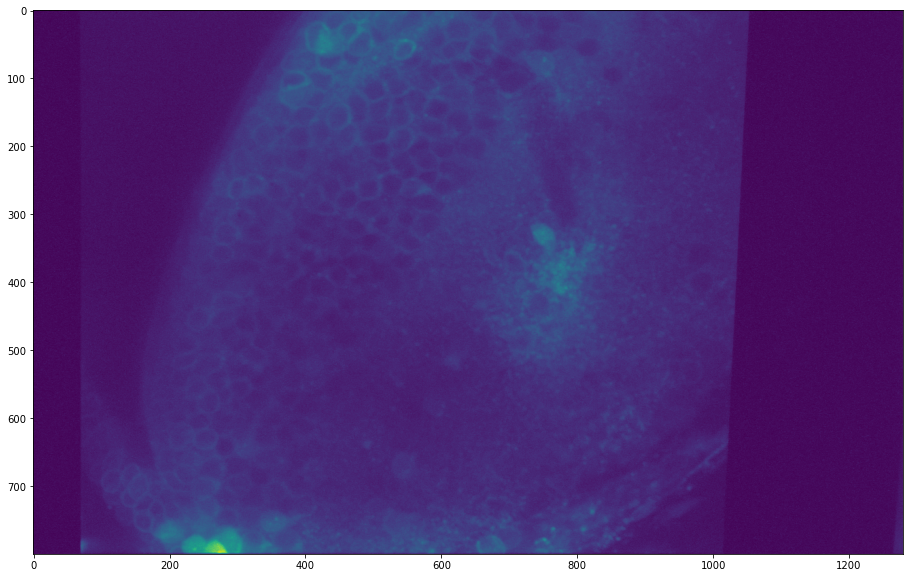

In [9]:
movie = tifffile.imread(TIFF_FILE)
std_project = np.std(movie, axis=0)
plt.imshow(std_project)

1843

In [74]:
# PAINT THE ROI IN THE NAPARI WINDOW
ROI = np.zeros(std_project.shape)
ROI = ROI.astype('int')

          
    
roi_painter = napari.Viewer()
roi_painter.add_image(std_project)
roi_painter.add_image(movie)
roi_painter.add_labels(ROI)


<Labels layer 'ROI' at 0x7fda136f8f70>

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


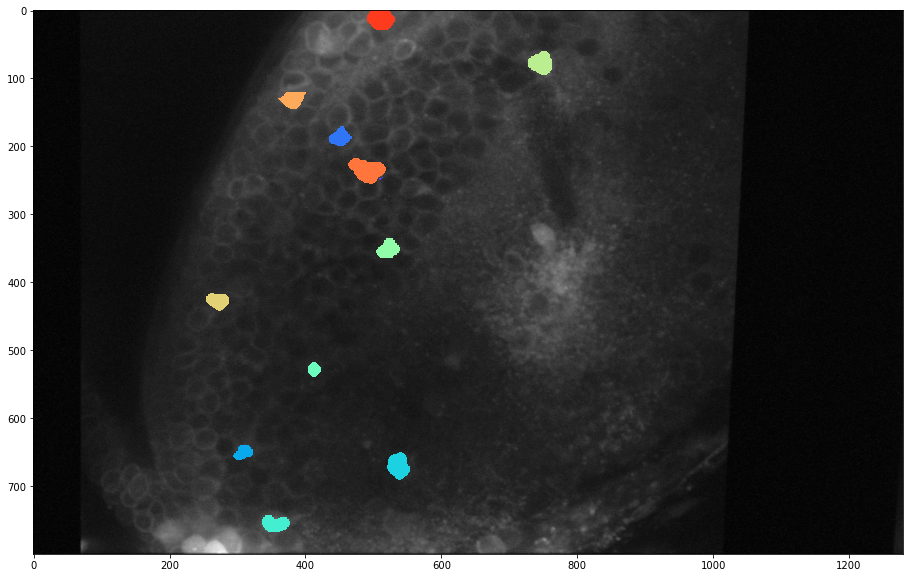

In [52]:
# DISPLAY THE IMAGING AREA AND ROIs
plt.imshow(std_project, cmap='Greys_r')
ROI_LABLES = np.unique(ROI)
print(ROI_LABLES)
for roi in ROI_LABLES:
    if roi > 0:
        mask = ROI.copy()
        mask = mask.astype('float')
        mask[mask!=roi] = np.nan      
        plt.imshow(mask, cmap='rainbow', vmin=0, vmax=len(ROI_LABLES))

In [79]:

ROI_LABLES = np.unique(ROI)
raw_dict = {}
dff_dict = {}
for roi in ROI_LABLES:
    if roi > 0:
        mask = ROI.copy()
        mask = mask.astype('float')
        mask[mask!=roi] = 0
        mask[mask!=0] = 1
        
        # Return the average intensity value for the roi
        roi_trace = returnROITrace(movie, mask)
        
        # Added the trace a to dictionary
        raw_dict[roi] = roi_trace
        
        # Remove shot noise
        roi_trace = okada(roi_trace)
        
        # Calculate Df/F
        roi_trace = deltaFOverF0(roi_trace, HZ)
        dff_dict[roi] = roi_trace

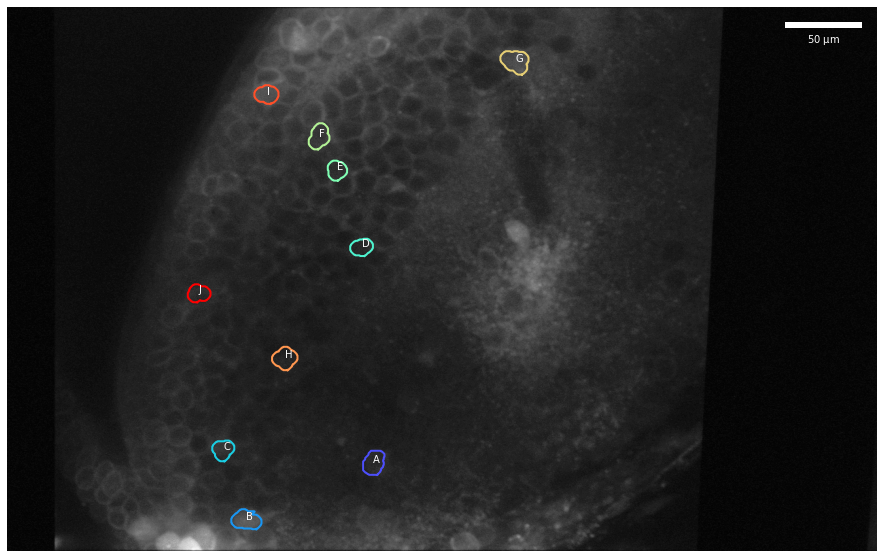

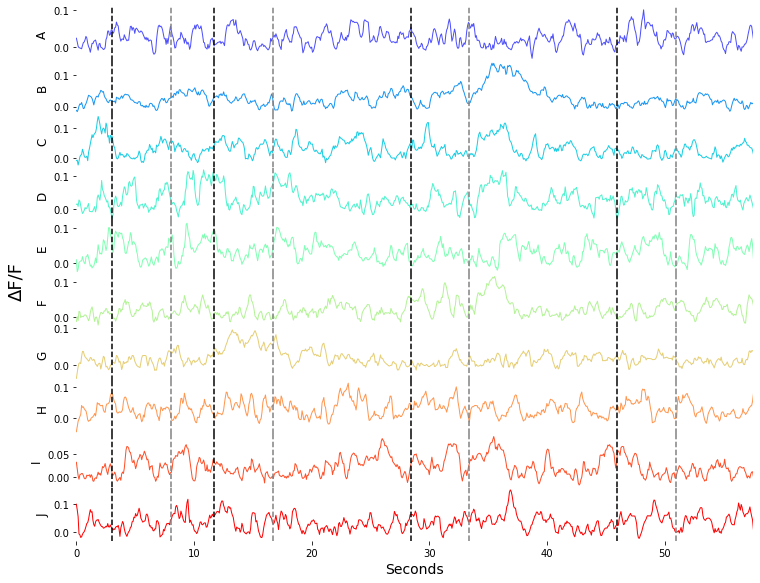

In [80]:
# Graph the ROI overs the STD projection and plot DF/F traces

rainbow = cm.get_cmap('rainbow', len(ROI_LABLES))
time = np.arange(movie.shape[0])/HZ


fig2, ax1 = plt.subplots()
ax1.axis("off")
scalebar = sb.ScaleBar(
    .44,
    "um",
    box_color =None,
    box_alpha=0,
    length_fraction=0.1,
    scale_loc="bottom",
    border_pad=1,
    pad=.5,
    color ='white'
)
ax1.add_artist(scalebar)
fig, axs = plt.subplots((len(ROI_LABLES)-1), sharex=True,figsize=(10, 8) )
fig.tight_layout()
fig.text(-0.05,0.5, "ΔF/F", ha="center", va="center", rotation=90, fontsize=18)
ax1.imshow(std_project, cmap='Greys_r')

for roi in ROI_LABLES:
    if roi > 0:
        mask = ROI.copy()
        mask[mask!=roi] = 0
        mask[mask!=0] = 1
        com = ndi.center_of_mass(mask)
        contour = measure.find_contours(mask, .3)
        ax1.plot(contour[0][:, 1],contour[0][:, 0], linewidth=2, color=rainbow(roi/ROI_LABLES.max()))
        ax1.text(com[1],com[0], s=str(chr(64+int(roi))), color='white')
        
        
        axs[int(roi)-1].plot(time, dff_dict[roi], linewidth=1, color=rainbow(roi/ROI_LABLES.max()))
        axs[int(roi)-1].set_xlim([0,np.max(time)])
        for stim in start:
            axs[int(roi)-1].axvline(x=(stim), ls='--', color='black')
        for stim in stop:
            axs[int(roi)-1].axvline(x=(stim), ls='--', color='grey')
        axs[int(roi)-1].set_ylabel(str(chr(64+int(roi))),  fontsize=12)        
        axs[int(roi)-1].spines['top'].set_visible(False)
        axs[int(roi)-1].spines['right'].set_visible(False)
        axs[int(roi)-1].spines['bottom'].set_visible(False)
        axs[int(roi)-1].spines['left'].set_visible(False)
        if int(roi) == (len(ROI_LABLES)-1):
            axs[int(roi)-1].set_xlabel('Seconds',  fontsize=14)
        else:
            axs[int(roi)-1].xaxis.set_ticks_position('none')

plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig(os.path.split(FILE)[0]+"/trace.svg")
#fig2.savefig(os.path.split(FILE)[0]+"/dendrite.svg")

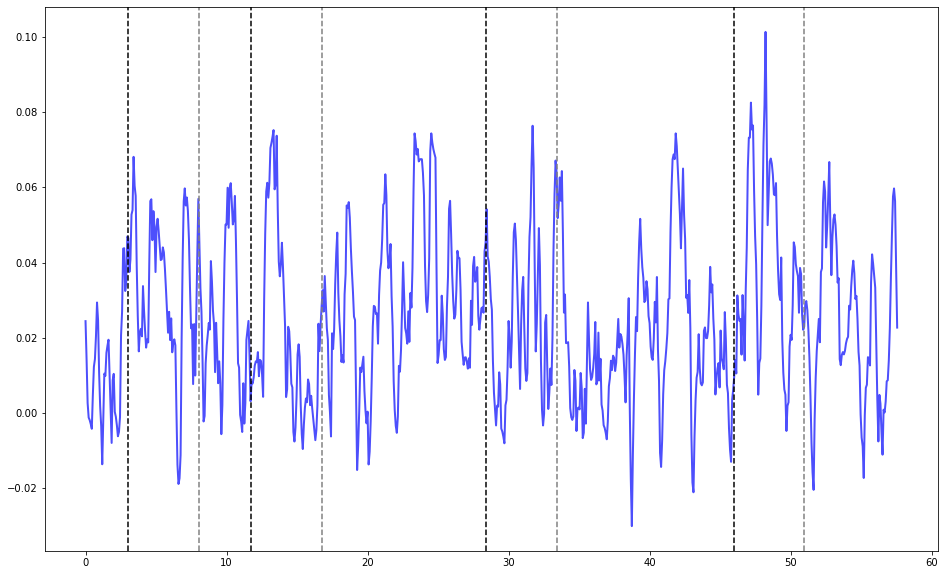

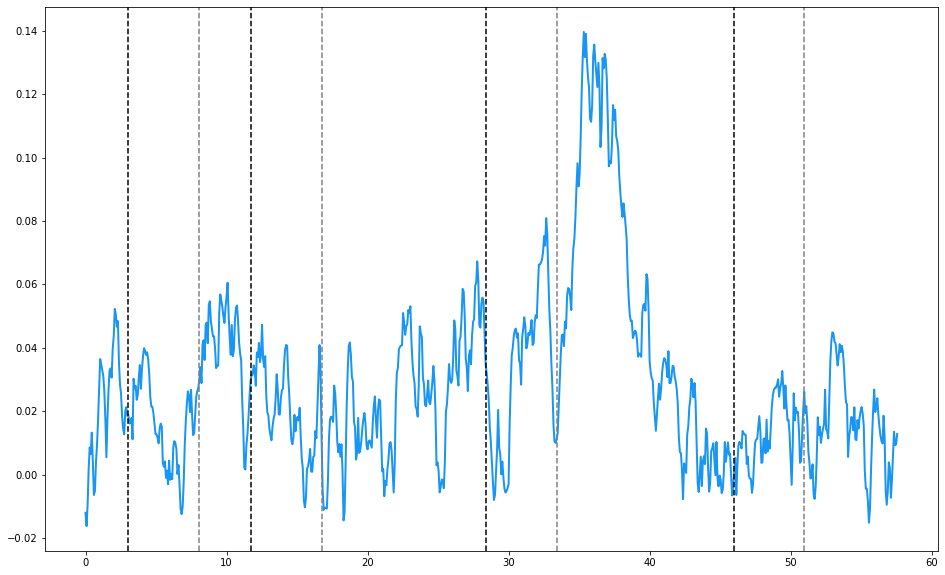

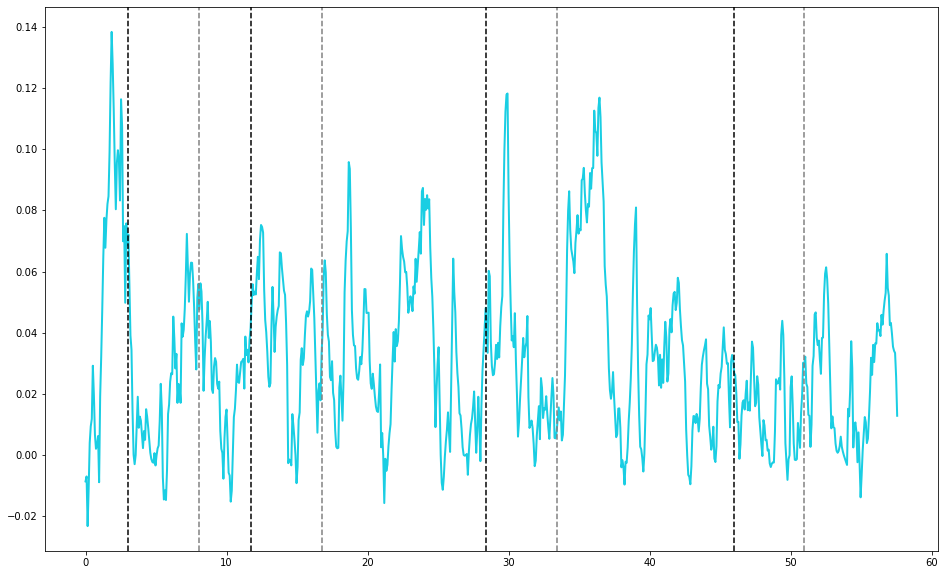

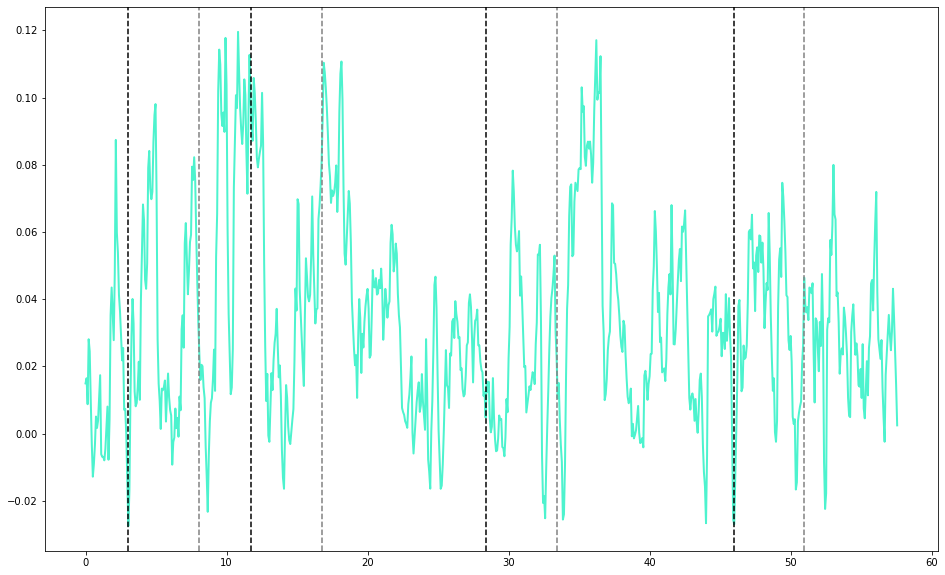

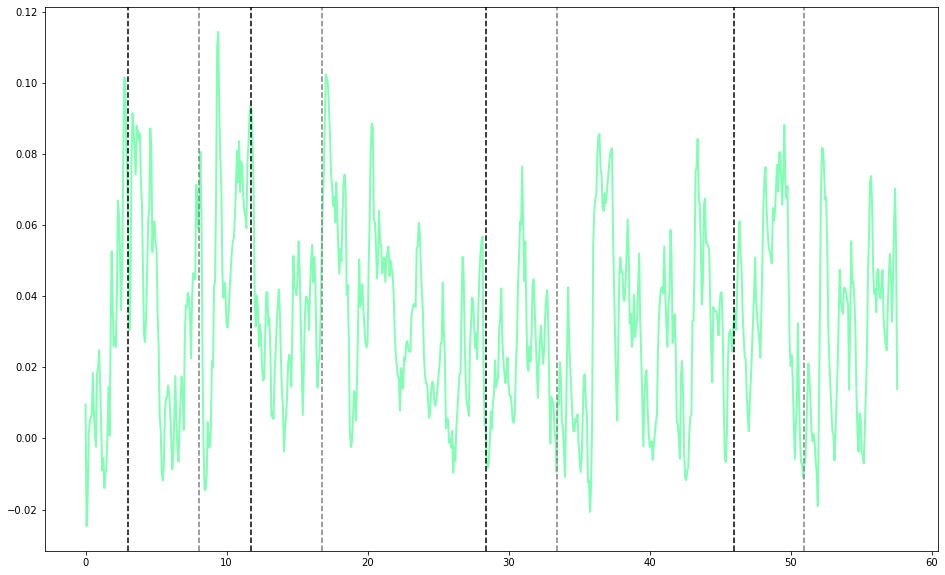

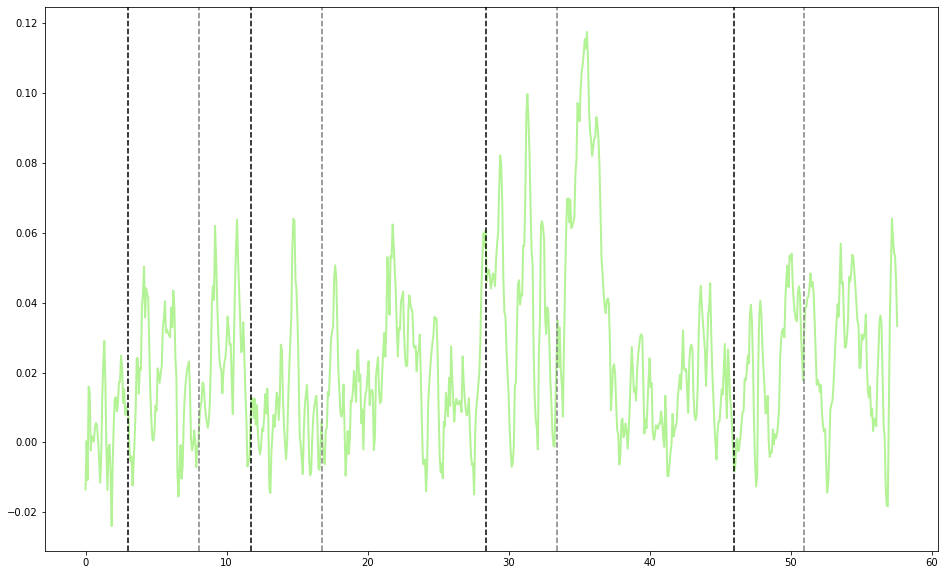

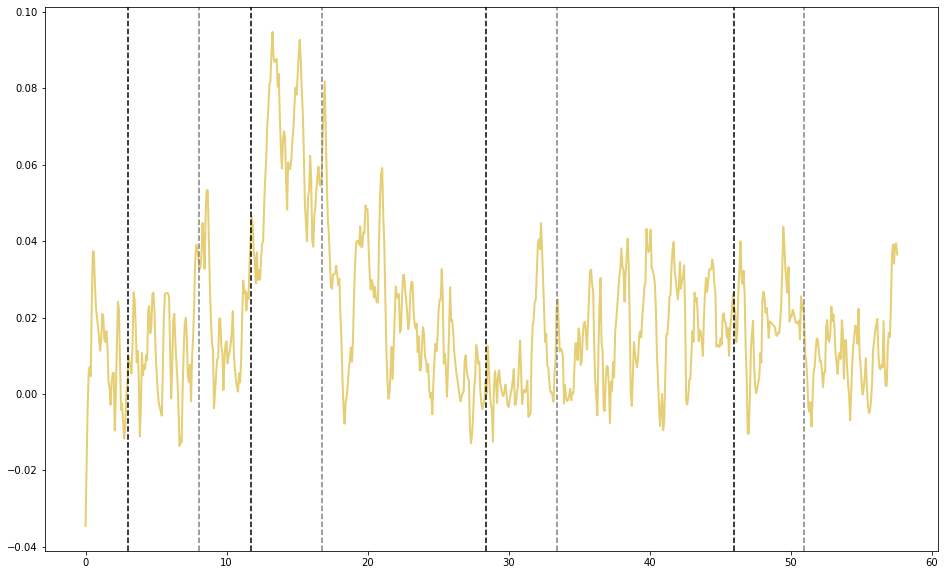

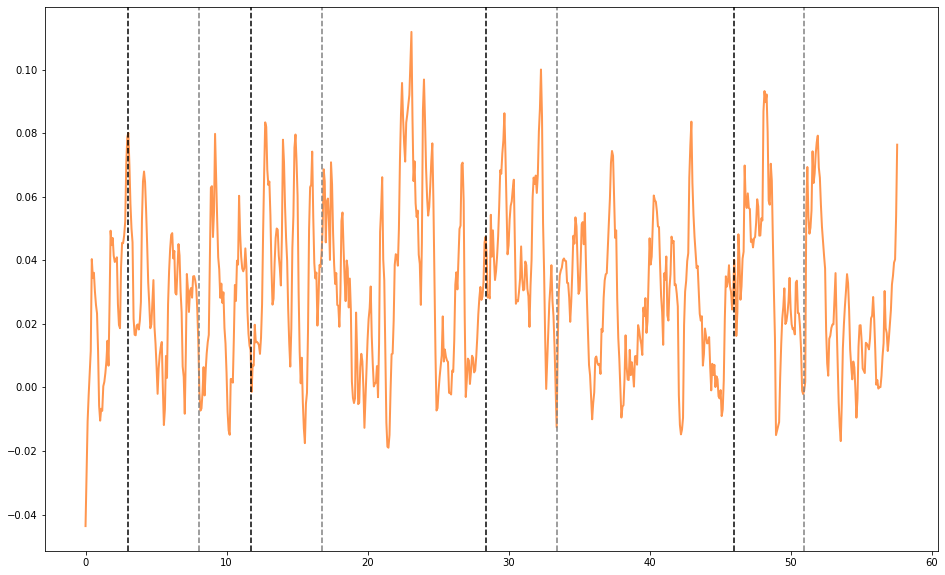

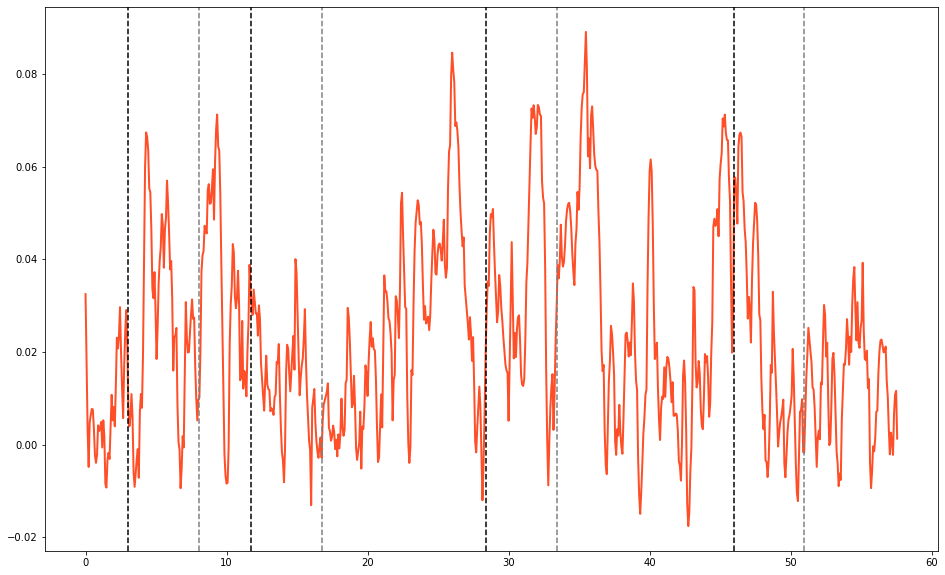

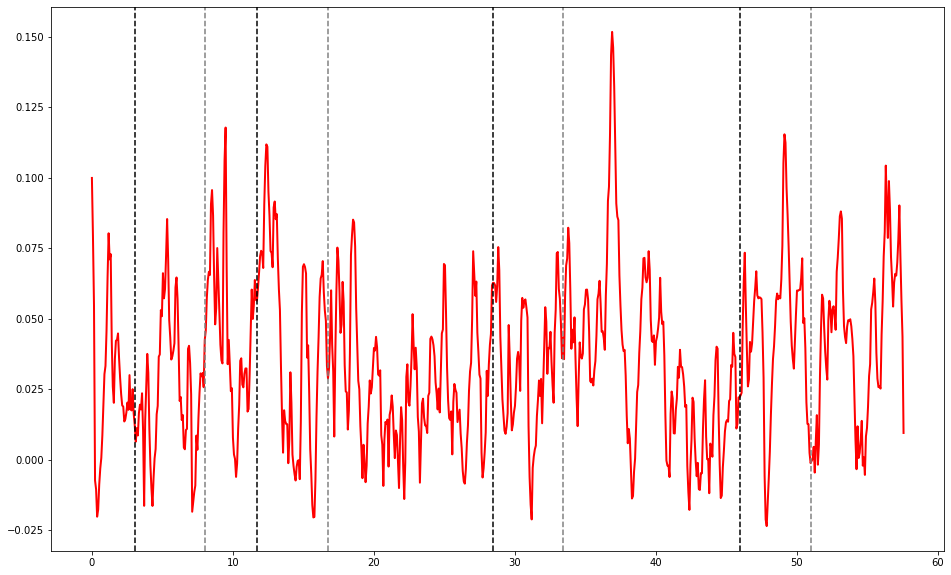

In [81]:
for roi in ROI_LABLES:
    if roi > 0:
        plt.plot(time, dff_dict[roi], linewidth=2, color=rainbow(roi/ROI_LABLES.max()))
        for stim in start:
            plt.axvline(x=(stim), ls='--', color='black')
        for stim in stop:
            plt.axvline(x=(stim), ls='--', color='grey')
        plt.show()